<a href="https://colab.research.google.com/github/LeNovice/PSW/blob/main/Better_CadenceNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
USE_ORIGINAL = 0
loss = 'categorical_crossentropy'

In [ ]:
import tensorflow_datasets as tfds
import numpy as np
#For plotting the dataset
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
#Data pipeline preparation
import tensorflow as tf
from tensorflow.keras import layers
#model building
from tensorflow.keras import models
import tensorflow.keras.utils as tfutils
import os
import copy

In [ ]:
NUM_CLASSES = 10

DataSet = 'cifar10'
#'caltech101'
#'cifar10'
def num_samples_per_class(ds_train, get_top_10 = False, print_all = False):
    vals = np.unique(np.fromiter(ds_train.map(lambda x, y: y), int), return_counts=True)
    class_list = []
    class_hist = []
    for val,count in zip(*vals):
        if print_all==True:
            print(int(val), count)
        class_hist.append((val,count))
    if get_top_10 == True:
        sorted_tuple = sorted(class_hist, key=lambda t: t[-1], reverse=True)[:(NUM_CLASSES + 1)]    #+1 because we are going to remove "backround_google" i.e. 4
        class_list = [x for x,y in sorted_tuple]
    return class_list

def filter_fn(x, allowed_classes:list):
    allowed_classes = tf.constant(allowed_classes)
    isallowed = tf.equal(allowed_classes, tf.cast(x, allowed_classes.dtype))
    reduced_sum = tf.reduce_sum(tf.cast(isallowed, tf.float32))
    return tf.greater(reduced_sum, tf.constant(0.))

In [ ]:
#ds_train = tfds.load(DataSet, split='train + test[:75%]', as_supervised=True)
if DataSet == 'caltech101':
    ds_train, train_info = tfds.load(DataSet, split='test[0:90%]', as_supervised=True, with_info = True)
    ds_test = tfds.load(DataSet, split='train', as_supervised=True)
    ds_val = tfds.load(DataSet, split='test[90%:]', as_supervised=True) 
else:
    ds_train, train_info = tfds.load(DataSet, split='train[0:80%]', as_supervised=True, with_info = True)   #taking 0 to 80% for training
    ds_test = tfds.load(DataSet, split='test', as_supervised=True)        
    ds_val = tfds.load(DataSet, split='test[80%:]', as_supervised=True)                                     #taking data from 80% point to the end of the dataset (100%) for validation


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/3.0.2.incompleteTVWP2N/cifar10-train.tfrecord*...:   0%|          …

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/3.0.2.incompleteTVWP2N/cifar10-test.tfrecord*...:   0%|          |…

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


In [ ]:
class_list = num_samples_per_class(ds_train, get_top_10=True)
if DataSet == 'caltech101':
  class_list = [i for i in class_list if i != train_info.features['label'].str2int('background_google')]
  class_list.sort()

"""for name in train_info.features['label'].names:
    print(name, train_info.features['label'].str2int(name))
"""

class_names = [train_info.features['label'].int2str(i) for i in class_list]
display(class_names)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [ ]:
resized_ds_train = ds_train.filter(lambda x, y: filter_fn(y, class_list)) # as_supervised
resized_ds_test = ds_test.filter(lambda x, y: filter_fn(y, class_list))
resized_ds_val = ds_val.filter(lambda x, y: filter_fn(y, class_list))

In [ ]:
num_samples_per_class(resized_ds_train, print_all=True)

0 5000
1 5000
2 5000
3 5000
4 5000
5 5000
6 5000
7 5000
8 5000
9 5000


[]

In [ ]:
num_samples_per_class(resized_ds_test, print_all=True)

0 1000
1 1000
2 1000
3 1000
4 1000
5 1000
6 1000
7 1000
8 1000
9 1000


[]

In [ ]:
num_samples_per_class(resized_ds_val, print_all=True)

In [ ]:
#Hyperparameters
if DataSet=='caltech101':
    IMG_SIZE = 60
elif DataSet=='cifar10':
    IMG_SIZE = 32
NUM_CHANNELS = 3
BATCH_SIZE=128

input_shape = (IMG_SIZE,IMG_SIZE,NUM_CHANNELS)
#Relabelling to avoid issues. Note that human readability is reduced by this
table = tf.lookup.StaticHashTable(
    initializer=tf.lookup.KeyValueTensorInitializer(
        keys=tf.constant(class_list, dtype=tf.int64),
        #values=tf.constant([tfutils.to_categorical(0, num_classes=NUM_CLASSES, dtype=np.int64), tfutils.to_categorical(1, num_classes=NUM_CLASSES, dtype=np.int64), tfutils.to_categorical(2, num_classes=NUM_CLASSES, dtype=np.int64), tfutils.to_categorical(3, num_classes=NUM_CLASSES, dtype=np.int64), tfutils.to_categorical(4, num_classes=NUM_CLASSES, dtype=np.int64), tfutils.to_categorical(5, num_classes=NUM_CLASSES, dtype=np.int64), tfutils.to_categorical(6, num_classes=NUM_CLASSES, dtype=np.int64), tfutils.to_categorical(7, num_classes=NUM_CLASSES, dtype=np.int64), tfutils.to_categorical(8, num_classes=NUM_CLASSES, dtype=np.int64), tfutils.to_categorical(9, num_classes=NUM_CLASSES, dtype=np.int64)],  dtype=tf.int64),
        values=tf.constant([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],  dtype=tf.int64)
    ),
    default_value= tf.constant(0,  dtype=tf.int64)
)

#This function will be used in the graph execution hence @tf.function prefix
@tf.function
def map_func(label):
    global class_list
    global loss
    mapped_label = table.lookup(label)
    if loss != 'sparse_categorical_crossentropy':
        mapped_label = tf.one_hot(indices=mapped_label, depth=NUM_CLASSES)
    print("Label = " + str(label) + "\t" + "Mapped Label = " + str(mapped_label))
    return mapped_label

#Preprocessing done as part of the graph
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMG_SIZE, IMG_SIZE),
  layers.Rescaling(1./255)
])

resize_layer = tf.keras.Sequential([
  layers.Resizing(IMG_SIZE, IMG_SIZE),
])

data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

buffer_size = 30*NUM_CLASSES

#Preprocessing function which invokes above graphs
def prepare(ds, shuffle=False, augment=False, resize_only = False):
    global buffer_size
    global BATCH_SIZE
    

    # Resize and rescale all datasets.
    if resize_only==True:
        ds = ds.map(lambda x, y: (resize_layer(x), map_func(y)), num_parallel_calls=tf.data.AUTOTUNE)
    else:
        ds = ds.map(lambda x, y: (resize_and_rescale(x), map_func(y)), num_parallel_calls=tf.data.AUTOTUNE)
    
    if shuffle:
        ds = ds.shuffle(buffer_size)
        
    # Batch all datasets.
    #ds = ds.batch(BATCH_SIZE)

    # Use data augmentation only on the training set.
    if augment:
        #f_ds = ds.filter(lambda x, y: filter_fn(y, [2,3,6]))    #[2,3,6] are the examples with lesser data. We are trying to bring back balance
        #f_ds_aug = f_ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)
        #ds = ds.concatenate(f_ds_aug)
        #ds_aug = ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)
        #ds = ds.concatenate(ds_aug)
        ds_aug = ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)
        ds = ds.concatenate(ds_aug)

        
    # Use buffered prefetching on all datasets.
    return ds.prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
resized_ds_train = prepare(resized_ds_train, augment=True)
resized_ds_test = prepare(resized_ds_test)
resized_ds_val = prepare(resized_ds_val)

Label = Tensor("label:0", shape=(), dtype=int64)	Mapped Label = Tensor("one_hot:0", shape=(10,), dtype=float32)


<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.], dtype=float32)>

<tf.Tensor: shape=(), dtype=int64, numpy=7>

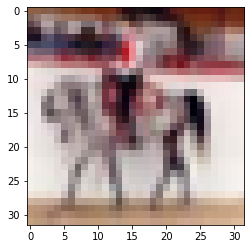

In [ ]:
for example in resized_ds_train.take(1):
  plt.imshow(example[0])
  display((example[-1]))
  display(tf.argmax(example[-1]))
  #display(train_info.features['label'].int2str(example[-1]))

In [ ]:
def num_samples_per_class_onehot(resized_ds_train, print_all=False):
    if loss != 'sparse_categorical_crossentropy':
        vals = np.unique(np.fromiter(resized_ds_train.map(lambda x, y: tf.argmax(y)), int), return_counts=True)
    else:
        vals = np.unique(np.fromiter(resized_ds_train.map(lambda x, y: y), int), return_counts=True)
    class_list = []
    class_hist = []
    for val,count in zip(*vals):
        if print_all==True:
            print(int(val), count)
        class_hist.append((val,count))
    class_hist.sort()
    return class_hist



In [ ]:
#Post prepare function, all the labels will be converted to one hot encoders. In order to get class-wise distribution, we will need to convert each one hot encoder into its label (temporarily)
#We need a new function to handle it
class_hist = num_samples_per_class_onehot(resized_ds_train)
display(class_hist)

[(0, 10000),
 (1, 10000),
 (2, 10000),
 (3, 10000),
 (4, 10000),
 (5, 10000),
 (6, 10000),
 (7, 10000),
 (8, 10000),
 (9, 10000)]

In [ ]:
#reg = tf.keras.regularizers.L2(0.01)
reg = tf.keras.regularizers.L1L2(l1 =0.0, l2 = 0.1)
#reg = tf.keras.regularizers.L1L2(l1 =0.0, l2 = 0.0)
#beta_regularizer = 0.1
#gamma_regularizer = 0.1

model = models.Sequential()
kernel_size = (3,3)
pool_size = (2,2)
if USE_ORIGINAL == 1:
	display("Original CadenceNet")
	#model.add(resize_and_rescale)
	#model.add(data_augmentation)
	kernel_size = (5,5)
	model.add(layers.Conv2D(64, kernel_size, input_shape = input_shape, padding="same", kernel_regularizer = reg))       #TODO: For instance, after a Conv2D layer with data_format="channels_first", set axis=1 in BatchNormalization.
	model.add(layers.BatchNormalization())
	model.add(layers.ReLU())
	pool_size = (2,2)
	model.add(layers.MaxPool2D(pool_size))
	model.add(layers.Dropout(.2))

	kernel_size = (3,3)
	model.add(layers.Conv2D(192, kernel_size, padding="same", kernel_regularizer = reg))      #TODO: For instance, after a Conv2D layer with data_format="channels_first", set axis=1 in BatchNormalization.
	model.add(layers.BatchNormalization())                                                      #beta_regularizer = beta_regularizer, gamma_regularizer = gamma_regularizer
	model.add(layers.ReLU())
	pool_size = (2,2)
	model.add(layers.MaxPool2D(pool_size))
	model.add(layers.Dropout(.2))
	#model.add(layers.SpatialDropout2D(0.2))
	
	kernel_size = (3,3)
	model.add(layers.Conv2D(64, kernel_size, padding="same", kernel_regularizer = reg))       #TODO: For instance, after a Conv2D layer with data_format="channels_first", set axis=1 in BatchNormalization.
	model.add(layers.BatchNormalization())
	model.add(layers.ReLU())
	model.add(layers.Dropout(.2))

	kernel_size = (3,3)
	model.add(layers.Conv2D(128, kernel_size, padding="same", kernel_regularizer = reg))      #TODO: For instance, after a Conv2D layer with data_format="channels_first", set axis=1 in BatchNormalization.
	model.add(layers.BatchNormalization())
	model.add(layers.ReLU())
	pool_size = (2,2)
	model.add(layers.MaxPool2D(pool_size))
	model.add(layers.Dropout(.2))
	#model.add(layers.SpatialDropout2D(0.2))

	model.add(layers.Flatten())
	model.add(layers.Dropout(.2))
	#model.add(layers.Dense(NUM_CLASSES, activation='softmax', kernel_regularizer = reg))
	model.add(layers.Dense(NUM_CLASSES, kernel_regularizer = reg))
	model.add(layers.Softmax())
else:
	display("VGG based CadenceNet")
	
	model.add(layers.Conv2D(32, kernel_size, kernel_initializer='he_uniform', kernel_regularizer = reg, padding='same', input_shape=(IMG_SIZE, IMG_SIZE, NUM_CHANNELS)))
	model.add(layers.BatchNormalization())
	model.add(layers.ReLU())
	model.add(layers.Conv2D(32, kernel_size, kernel_initializer='he_uniform', kernel_regularizer = reg, padding='same'))
	model.add(layers.BatchNormalization())
	model.add(layers.ReLU())
	model.add(layers.MaxPooling2D(pool_size))
	model.add(layers.Dropout(0.1))
	
	model.add(layers.Conv2D(64, kernel_size, kernel_initializer='he_uniform', kernel_regularizer = reg, padding='same'))
	model.add(layers.BatchNormalization())
	model.add(layers.ReLU())
	model.add(layers.Conv2D(64, kernel_size, kernel_initializer='he_uniform', kernel_regularizer = reg, padding='same'))
	model.add(layers.BatchNormalization())
	model.add(layers.ReLU())
	model.add(layers.MaxPooling2D(pool_size))
	model.add(layers.Dropout(0.2))
	
	model.add(layers.Conv2D(128, kernel_size, kernel_initializer='he_uniform', kernel_regularizer = reg, padding='same'))
	model.add(layers.BatchNormalization())
	model.add(layers.ReLU())
	model.add(layers.Conv2D(128, kernel_size, kernel_initializer='he_uniform', kernel_regularizer = reg, padding='same'))
	model.add(layers.BatchNormalization())
	model.add(layers.ReLU())
	model.add(layers.MaxPooling2D(pool_size))
	model.add(layers.Dropout(0.3))
	
	model.add(layers.Flatten())
	model.add(layers.Dense(128, kernel_initializer='he_uniform', kernel_regularizer = reg))
	if 0:
		"""
		The converter quantizes batchnorm iff it follows a Conv2D layer. Hence we remove this BatchNorm layer (although it helps in accuracy).
		So we trade off accuracy for smaller model size
		"""
		model.add(layers.BatchNormalization())
	model.add(layers.ReLU())
	model.add(layers.Dropout(0.2))
	model.add(layers.Dense(NUM_CLASSES, kernel_regularizer = reg))
	model.add(layers.Softmax())

'VGG based CadenceNet'

In [ ]:
def get_class_weights(class_hist):
    """
    Returns the class weights as a tf.Tensor. Class weights are inverse of the class frequencies
    Class frequencies are the number of samples of each class which we calculate in earlier steps
    """
    inv_freq = tf.convert_to_tensor([1.0/count for label, count in class_hist], dtype=tf.float32)
    return tfutils.normalize(inv_freq)


def weightedloss(y_true, y_pred, gamma, class_weight):
    """
    We assume that all arguments coming into this function are tf.Tensors type
    class_weights are basically alpha in focal loss paper
    """
    #ones = tf.convert_to_tensor(np.ones(shape=len(y_true)))
    a = tf.math.multiply(tf.math.pow(tf.math.subtract(1.0, y_pred), gamma), tf.math.log(y_pred))  #((1-pt)^gamma)log(pt)
    b = tf.math.multiply(-1.0, class_weight)                                                          #-alpha
    b = tf.math.multiply(b,a)    
    b = tf.math.multiply(b, y_true)
    return b
class WeightedLoss(tf.keras.losses.Loss):
    def __init__(self, gamma, class_weight=np.ones(shape=NUM_CLASSES, dtype=np.float32)):
        super().__init__()
        self.gamma = tf.convert_to_tensor(gamma)
        self.class_weight = tf.convert_to_tensor(class_weight, dtype=tf.float32)
    def call(self, y_true, y_pred):
        return weightedloss(y_true, y_pred, self.gamma, self.class_weight)

In [ ]:
Learning_Rate = 1e-5
#tf.keras.optimizers.Adam(learning_rate=Learning_Rate)     #OR tf.keras.optimizers.SGD(learning_rate=Learning_Rate, momentum=0.9)
opt = tf.keras.optimizers.Adam(learning_rate=Learning_Rate)

In [ ]:
###EITHER

#!pip install focal-loss
#from focal_loss import SparseCategoricalFocalLoss 
#model.compile( optimizer = opt, loss = SparseCategoricalFocalLoss(gamma=2), metrics=['accuracy'] )

In [ ]:
###OR
model.compile( optimizer = opt, loss = loss, metrics=['accuracy'] )

In [ ]:
###OR
#class_wts = get_class_weights(class_hist)
#display(class_wts)
#model.compile( optimizer = opt, loss = WeightedLoss(gamma=2.0, class_weight=class_wts), metrics=['accuracy'] )

In [ ]:
#model.summary()

In [ ]:
#h = model.fit( resized_ds_train, epochs=10)
resized_ds_train = resized_ds_train.batch(BATCH_SIZE)
#resized_ds_test_unbatched = resized_ds_test
#resized_ds_test = resized_ds_test.batch(BATCH_SIZE)
resized_ds_val = resized_ds_val.batch(BATCH_SIZE)

h = model.fit( resized_ds_train, epochs=80, validation_data = resized_ds_val)

Epoch 1/80
782/782 [==============================] - 55s 53ms/step - loss: 107.9815 - accuracy: 0.1315 - val_loss: 96.8646 - val_accuracy: 0.2032
Epoch 2/80
782/782 [==============================] - 42s 54ms/step - loss: 87.6565 - accuracy: 0.1964 - val_loss: 78.6112 - val_accuracy: 0.2963
Epoch 3/80
782/782 [==============================] - 41s 52ms/step - loss: 71.0744 - accuracy: 0.2589 - val_loss: 63.6762 - val_accuracy: 0.3485
Epoch 4/80
782/782 [==============================] - 40s 52ms/step - loss: 57.5508 - accuracy: 0.3064 - val_loss: 51.5167 - val_accuracy: 0.3785
Epoch 5/80
782/782 [==============================] - 41s 53ms/step - loss: 46.5530 - accuracy: 0.3399 - val_loss: 41.6499 - val_accuracy: 0.3973
Epoch 6/80
782/782 [==============================] - 41s 52ms/step - loss: 37.6679 - accuracy: 0.3685 - val_loss: 33.7254 - val_accuracy: 0.4138
Epoch 7/80
782/782 [==============================] - 41s 52ms/step - loss: 30.5614 - accuracy: 0.3921 - val_loss: 27.4464 

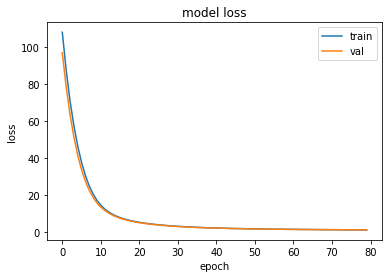

In [ ]:
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

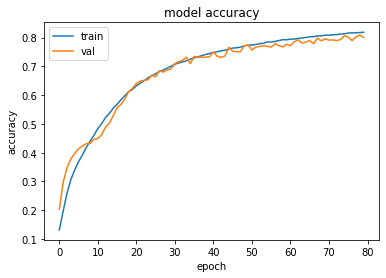

In [ ]:
plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
#Evaluation and confusion matrix creation:
from sklearn.metrics import classification_report, confusion_matrix

x_test = np.asarray(list(map(lambda x: x[0], tfds.as_numpy(resized_ds_test))))
y_test_orig = np.asarray(list(map(lambda x: x[1], tfds.as_numpy(resized_ds_test))))

In [ ]:
predictions = model.predict(x_test)

313/313 [==============================] - 1s 3ms/step


In [ ]:
if loss!='sparse_categorical_crossentropy':
    false_arr = np.full(shape=len(class_list), fill_value = False)
    #y_pred = np.empty(shape=y_test_orig.shape[-1])
    i=0
    for i, pred in enumerate(predictions):
        temp_arr = copy.deepcopy(false_arr)
        np.put(temp_arr, np.argmax(pred), True)
        if i==0:
            y_pred = copy.deepcopy(temp_arr)
        else:
            y_pred = np.vstack([y_pred, temp_arr])
    display(y_pred.shape)
else:
    y_pred = np.argmax(predictions, axis=1)


(10000, 10)

In [ ]:
display(y_test_orig.shape)
display(y_pred.shape)

(10000, 10)

(10000, 10)

In [ ]:
print('Confusion Matrix')
if loss != 'sparse_categorical_crossentropy':
    matrix = confusion_matrix(y_test_orig.argmax(axis=1), y_pred.argmax(axis=1))
else:
    matrix = confusion_matrix(y_test_orig, y_pred)
display(matrix)

# Print Classification Report
print('Classification Report')
print(classification_report(y_test_orig, y_pred, target_names=class_names))

Confusion Matrix


array([[745,  15, 124,   5,   5,   1,   2,  25,  34,  44],
       [  4, 863,   3,   3,   1,   0,   7,   4,   4, 111],
       [ 24,   0, 792,  23,  42,  16,  53,  37,   2,  11],
       [  7,   0,  85, 648,  39,  64,  69,  36,  11,  41],
       [  7,   1,  72,  23, 753,   5,  61,  65,   4,   9],
       [  7,   3,  71, 122,  37, 619,  41,  71,   5,  24],
       [  1,   0,  23,  24,  16,   1, 916,   9,   1,   9],
       [  6,   0,  26,  16,  21,  12,  11, 887,   3,  18],
       [ 60,  15,  23,   3,   3,   0,   8,   4, 837,  47],
       [  5,  21,   3,   1,   3,   0,   5,   9,   3, 950]])

Classification Report
              precision    recall  f1-score   support

    airplane       0.86      0.74      0.80      1000
  automobile       0.94      0.86      0.90      1000
        bird       0.65      0.79      0.71      1000
         cat       0.75      0.65      0.69      1000
        deer       0.82      0.75      0.78      1000
         dog       0.86      0.62      0.72      1000
        frog       0.78      0.92      0.84      1000
       horse       0.77      0.89      0.83      1000
        ship       0.93      0.84      0.88      1000
       truck       0.75      0.95      0.84      1000

   micro avg       0.80      0.80      0.80     10000
   macro avg       0.81      0.80      0.80     10000
weighted avg       0.81      0.80      0.80     10000
 samples avg       0.80      0.80      0.80     10000



NOT using below things

In [ ]:
def ret_as_numpy():
    #test = tfds.load(DataSet, split='test', as_supervised=True)
    #test = prepare(test)
    #test = tfds.as_numpy(test)
    return tfds.as_numpy(resized_ds_test)

In [ ]:
test_as_np = ret_as_numpy()

In [ ]:
def evaluate_float_model(model, test):
    test_labels = []
    
    # Run predictions on every image in the "test" dataset.
    prediction_digits = []
    for i, test_example in enumerate(test):
        if i % 1000 == 0:
            print('Evaluated on {n} results so far.'.format(n=i))
        test_labels.append(np.argmax(test_example[-1]))
        test_image = test_example[0]
        # Pre-processing: add batch dimension and convert to float32 to match with
        # the model's input data format.
        #display(test_image.shape)
        test_image = np.expand_dims(test_image, axis=0).astype(np.float32)
        #test_image = np.expand_dims(test_image, axis=3).astype(np.float32)
        #display(test_image.shape)
        
        # Run inference.
        output = model(test_image, training=False)
        # Post-processing: remove batch dimension and find the digit with highest
        # probability.
        output = output.numpy()
        #display(output[0])
        digit = np.argmax(output[0])
        prediction_digits.append(digit)
        
    print('\n')
    #display(output[0])
    #display(output)
    #display(digit)
    # Compare prediction results with ground truth labels to calculate accuracy.
    #display(prediction_digits)
    #display(test_labels)
    prediction_digits = np.array(prediction_digits)
    accuracy = (prediction_digits == test_labels).mean()
    return accuracy

In [ ]:
test_accuracy_Float = evaluate_float_model(model, test_as_np)

print('Float test_accuracy:', test_accuracy_Float)

Evaluated on 0 results so far.
Evaluated on 1000 results so far.
Evaluated on 2000 results so far.
Evaluated on 3000 results so far.
Evaluated on 4000 results so far.
Evaluated on 5000 results so far.
Evaluated on 6000 results so far.
Evaluated on 7000 results so far.
Evaluated on 8000 results so far.
Evaluated on 9000 results so far.


Float test_accuracy: 0.801


Float checkpoint

In [ ]:
! pip install -q tensorflow-model-optimization
import tensorflow_model_optimization as tfmot
quantize_model = tfmot.quantization.keras.quantize_model

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.9/238.9 KB 21.7 MB/s eta 0:00:00


In [ ]:
q_aware_model = quantize_model(model)
#TODO: Check why this is not possible with Adam
opt = tf.keras.optimizers.SGD(learning_rate=Learning_Rate, momentum=0.9)
q_aware_model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics=['accuracy'])
q_aware_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 quantize_layer (QuantizeLay  (None, 32, 32, 3)        3         
 er)                                                             
                                                                 
 quant_conv2d (QuantizeWrapp  (None, 32, 32, 32)       961       
 erV2)                                                           
                                                                 
 quant_batch_normalization (  (None, 32, 32, 32)       129       
 QuantizeWrapperV2)                                              
                                                                 
 quant_re_lu (QuantizeWrappe  (None, 32, 32, 32)       3         
 rV2)                                                            
                                                                 
 quant_conv2d_1 (QuantizeWra  (None, 32, 32, 32)      

In [ ]:
quantize_train, quant_train_info = tfds.load(DataSet, split='train + test[:75%]', with_info=True, as_supervised=True)
filtered_quantize_train = quantize_train.filter(lambda x, y: filter_fn(y, class_list))

resized_quantize_train = prepare(filtered_quantize_train)

In [ ]:
resized_quantize_train = resized_quantize_train.batch(BATCH_SIZE)
h = q_aware_model.fit(resized_quantize_train, epochs=5, validation_data = resized_ds_val)

Epoch 1/5
450/450 [==============================] - 37s 72ms/step - loss: 1.0570 - accuracy: 0.8732 - val_loss: 1.0572 - val_accuracy: 0.8587
Epoch 2/5
450/450 [==============================] - 27s 59ms/step - loss: 1.0264 - accuracy: 0.8831 - val_loss: 1.0426 - val_accuracy: 0.8623
Epoch 3/5
450/450 [==============================] - 20s 45ms/step - loss: 1.0070 - accuracy: 0.8885 - val_loss: 1.0193 - val_accuracy: 0.8718
Epoch 4/5
450/450 [==============================] - 21s 47ms/step - loss: 0.9940 - accuracy: 0.8910 - val_loss: 0.9983 - val_accuracy: 0.8758
Epoch 5/5
450/450 [==============================] - 21s 47ms/step - loss: 0.9818 - accuracy: 0.8944 - val_loss: 0.9818 - val_accuracy: 0.8807


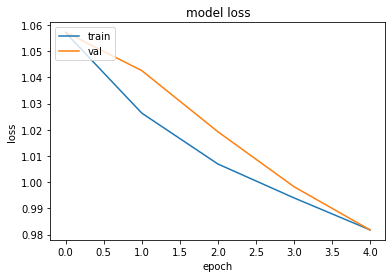

In [ ]:
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(q_aware_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

quantized_tflite_model = converter.convert()

/usr/local/lib/python3.8/dist-packages/tensorflow/lite/python/convert.py:765: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


In [ ]:
def evaluate_model(interpreter, test):
    test_labels = []


    input_index = interpreter.get_input_details()[0]["index"]
    output_index = interpreter.get_output_details()[0]["index"]
    
    # Run predictions on every image in the "test" dataset.
    prediction_digits = []
    for i, test_example in enumerate(test):
        if i % 1000 == 0:
            print('Evaluated on {n} results so far.'.format(n=i))
        test_labels.append(np.argmax(test_example[-1]))
        test_image = test_example[0]
        # Pre-processing: add batch dimension and convert to float32 to match with
        # the model's input data format.
        #display(test_image.shape)
        test_image = np.expand_dims(test_image, axis=0).astype(np.float32)
        #test_image = np.expand_dims(test_image, axis=3).astype(np.float32)
        #display(test_image.shape)
        interpreter.set_tensor(input_index, test_image)
        
        # Run inference.
        interpreter.invoke()
        
        # Post-processing: remove batch dimension and find the digit with highest
        # probability.
        output = interpreter.tensor(output_index)
        digit = np.argmax(output()[0])
        prediction_digits.append(digit)
        
    print('\n')
    # Compare prediction results with ground truth labels to calculate accuracy.
    prediction_digits = np.array(prediction_digits)
    accuracy = (prediction_digits == test_labels).mean()
    return accuracy

In [ ]:
#Models obtained from TfLiteConverter can be run in Python with Interpreter.
interpreter = tf.lite.Interpreter(model_content=quantized_tflite_model)
#Since TensorFlow Lite pre-plans tensor allocations to optimize inference, the user needs to call allocate_tensors() before any inference.
interpreter.allocate_tensors()

test_accuracy = evaluate_model(interpreter, test_as_np)

print('Quant TFLite test_accuracy:', test_accuracy)
#print('Quant TF test accuracy:', q_aware_model_accuracy)

Evaluated on 0 results so far.
Evaluated on 1000 results so far.
Evaluated on 2000 results so far.
Evaluated on 3000 results so far.
Evaluated on 4000 results so far.
Evaluated on 5000 results so far.
Evaluated on 6000 results so far.
Evaluated on 7000 results so far.
Evaluated on 8000 results so far.
Evaluated on 9000 results so far.


Quant TFLite test_accuracy: 0.8801


In [ ]:
MODEL_DIR = "CadenceNet_Float"
model.save(MODEL_DIR, save_format="tf")

In [ ]:
!pip install -U tf2onnx==1.8.4
!python -m tf2onnx.convert --saved-model /content/CadenceNet_Float/ --output /content/CadenceNetOriginal_Float.onnx

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.3/345.3 KB 25.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 73.3 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.19.6
    Uninstalling protobuf-3.19.6:
      Successfully uninstalled protobuf-3.19.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.11.0 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.3 which is incompatible.
2023-02-17 12:47:31.489101: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such 

In [ ]:
quant_file = "/content/CadenceNetOriginal_QAT.tflite"
open(quant_file, "wb").write(quantized_tflite_model)

1359408

In [ ]:

print("Float model in Mb: ", os.path.getsize("/content/CadenceNetOriginal_Float.onnx") / float(2**20))
print("Quantized model in Mb: ", os.path.getsize(quant_file) / float(2**20))
print("Float Model Accuracy: ", test_accuracy_Float)
print("Quantized Model Accuracy: ", test_accuracy)

Float model in Mb:  2.1094303131103516
Quantized model in Mb:  1.2964324951171875
Float Model Accuracy:  0.801
Quantized Model Accuracy:  0.8801


In [ ]:
!pip install onnxruntime
import onnxruntime as rt

sess = rt.InferenceSession("/content/CadenceNetOriginal_Float.onnx")
input_name = sess.get_inputs()[0].name
output_name = sess.get_outputs()[0].name
x = np.random.random((1,IMG_SIZE,IMG_SIZE,NUM_CHANNELS))
x = x.astype(np.float32)
res = sess.run([output_name], {input_name: x})


In [ ]:
indices = tf.convert_to_tensor([0, 1, 2])
depth = 3
indic = tf.convert_to_tensor([3, 5, 8])
tf.math.multiply(indices, indic)

